In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import pymultinest
%matplotlib inline
plt.style.use("classic")
mpl.rcParams['figure.figsize'] = (10.0, 10.0)
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['font.size']=14
mpl.rcParams['xtick.labelsize']=18
mpl.rcParams['ytick.labelsize']=18
mpl.rcParams['axes.labelsize']=20

In [11]:
fin = pymultinest.Analyzer(n_params = 8, outputfiles_basename='./nest_out/weibull')
post_dat = fin.get_equal_weighted_posterior()

  analysing data from ./nest_out/weibull.txt


In [12]:
mxlik = post_dat[:,-1]
mxchain = post_dat[:,:-1]
indmax = np.argmax(mxlik)
#mxchain[:,0] = np.log10(mxchain[:,0])
dat = mxchain

r = dat[:, 0]
k = dat[:, 1]

In [13]:
print r[indmax], k[indmax]

1.1887133839415978 0.8529652628924201


In [21]:
rate = 1.0
row, col = dat.shape
indx = np.arange(0, col)
npar = col

rangedat = np.zeros((col, 2))
dat = dat[np.ix_(np.arange(int(row - row * rate), row), indx)]
likli = mxlik[np.ix_(np.arange(int(row - row * rate), row))]
row, col = dat.shape
for i in range(0, col):
    rangedat[i, 0] = np.min(dat[:, i])
    rangedat[i, 1] = np.max(dat[:, i])

for vari in range(0, npar):
    for ls in [0.683, 0.955]:
        histc, bin_edges = np.histogram(dat[:, vari], density=True, bins=50)
        vom = (bin_edges[:-1]+bin_edges[1:])*0.5
        bw = bin_edges[1:]-bin_edges[:-1]
        pd = histc/float(np.sum(histc))/bw
        ind = np.argsort(histc)
        ind = ind[::-1]
        v = histc.copy()
        v[0] = histc[ind[0]]
        for i in range(1, len(ind)):
            v[i] = v[i-1]+histc[ind[i]]

        v = v/float(np.sum(histc))
        thre = histc[ind[np.where((v[:-1] < ls) & (v[1:]>=ls))][0]]

        lv = np.min(vom[histc>=thre])
        rv = np.max(vom[histc>=thre])
        if vari==0:
            b_r = vom
            pd_r = pd
            if ls==0.683:
                lv_r68 = lv
                rv_r68 = rv
            if ls==0.955:
                lv_r95 = lv
                rv_r95 = rv
        if vari==1:
            b_k = vom
            pd_k = pd
            if ls==0.683:
                lv_k68 = lv
                rv_k68 = rv
            if ls==0.955:
                lv_k95 = lv
                rv_k95 = rv

In [23]:
max_ticks = 3
levels = [0.683, 0.955]

In [24]:
vari = 1
varj = 0

x = dat[:, varj]
y = dat[:, vari]

ind = ((x < rangedat[varj, 1]) & (x > rangedat[varj, 0]) & (y < rangedat[vari, 1]) & (y > rangedat[vari, 0]))
liklisub = likli[ind]
x = dat[ind, varj]
y = dat[ind, vari]

ngridx = 30
ngridy = 30

H, xedges, yedges = np.histogram2d(x, y, bins=(ngridx, ngridy), range=(rangedat[0, :], rangedat[1, :]))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
H = H.transpose()
xedges = (xedges[:-1] + xedges[1:]) / 2
yedges = (yedges[:-1] + yedges[1:]) / 2
mxx, mxy = np.meshgrid(xedges, yedges)

indx, indy = np.meshgrid(np.arange(0, ngridx), np.arange(0, ngridy))
vmx2 = np.squeeze(np.reshape(mxx, (-1, 1)));
vmy2 = np.squeeze(np.reshape(mxy, (-1, 1)));
vm = np.squeeze(np.reshape(H, (-1, 1)));

vx = np.squeeze(np.reshape(indx, (-1, 1)));
vy = np.squeeze(np.reshape(indy, (-1, 1)));
#Sort according to likelihood
vm2 = np.sort(vm)[::-1];
#Get index and convert everything to array
ix = np.argsort(vm, axis=0)[::-1];
ix = np.ix_(ix);
vx2 = vx[ix];
vy2 = vy[ix];
vmx2 = vmx2[ix];
vmy2 = vmy2[ix];
#get the cumulative of the hisogram
vm2 = np.cumsum(vm2 / np.sum(vm2));
cmxx2 = H;
mxx2 = mxx;
mxy2 = mxy;
#Form 2D cumulative plot
for ki in range(0, len(vm2)):
    mxx2[vy2[ki], vx2[ki]] = vmx2[ki];
    mxy2[vy2[ki], vx2[ki]] = vmy2[ki];
    cmxx2[vy2[ki], vx2[ki]] = vm2[ki];

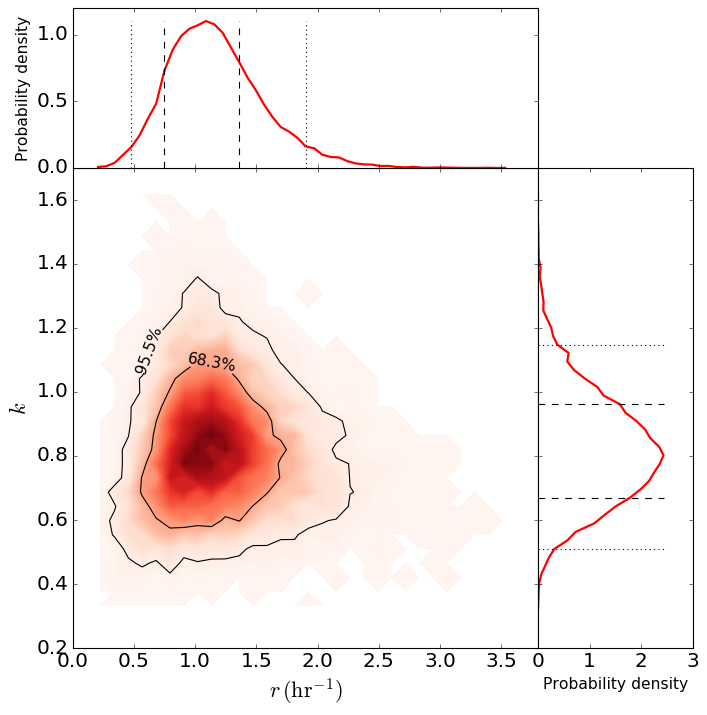

In [28]:
fig = plt.figure()
gs = GridSpec(4, 4)
fig.subplots_adjust(hspace=0, wspace=0)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0:1,0:3], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1:4,3], sharey=ax_joint)
#myfmt = {'%2f%%'%levels}
ax_joint.contourf(mxx, mxy, H, 100, cmap='Reds_r')
conls = ax_joint.contour(mxx2, mxy2, cmxx2, levels, colors='k')
ax_joint.clabel(conls, fmt='{:.1%}'.format, inline=1, fontsize=14)
ax_joint.set_xlim(0, 3.8)
ax_joint.set_ylim(0.2, 1.7)
#yloc = ax_joint.set_MaxNLocator(max_yticks)
#xloc = ax_joint.set_MaxNLocator(max_yticks)

ax_marg_x.plot(b_r, pd_r, color='red', linewidth=2)
ax_marg_x.yaxis.set_major_locator(mticker.MaxNLocator(max_ticks))
ax_marg_x.plot([lv_r68, lv_r68], [0, max(pd_r)], ls='dashed', color='k', linewidth=1)
ax_marg_x.plot([rv_r68, rv_r68], [0, max(pd_r)], ls='dashed', color='k', linewidth=1)
ax_marg_x.plot([lv_r95, lv_r95], [0, max(pd_r)], ls='dotted', color='k', linewidth=1)
ax_marg_x.plot([rv_r95, rv_r95], [0, max(pd_r)], ls='dotted', color='k', linewidth=1)
plt.setp(ax_marg_x.get_xticklabels(), visible=False)

#ax_marg_y.invert_yaxis()
ax_marg_y.plot(pd_k, b_k, color='red', linewidth=2)
ax_marg_y.xaxis.set_major_locator(mticker.MaxNLocator(max_ticks))
ax_marg_y.plot([0, max(pd_k)], [lv_k68, lv_k68], ls='dashed', color='k', linewidth=1)
ax_marg_y.plot([0, max(pd_k)], [rv_k68, rv_k68], ls='dashed', color='k', linewidth=1)
ax_marg_y.plot([0, max(pd_k)], [lv_k95, lv_k95], ls='dotted', color='k', linewidth=1)
ax_marg_y.plot([0, max(pd_k)], [rv_k95, rv_k95], ls='dotted', color='k', linewidth=1)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)


# Set labels on joint
ax_joint.set_xlabel(r'$r\,(\mathrm{hr}^{-1})$')
#ax_joint.set_ylabel(r'$\rm DM_E (cm^{-3}\,pc)$')
ax_joint.set_ylabel(r'$k$')

# Set labels on marginals
ax_marg_x.set_ylabel('Probability density', fontsize=14)
ax_marg_y.set_xlabel('Probability density', fontsize=14)

plt.savefig('./plots/brate_weib.pdf')
plt.show()